In [1]:
from google.colab import drive

drive.mount('/content/drive')
%cd drive/MyDrive/PCM/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/PCM


In [2]:
# Importing the libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

##Data Preprocessing

In [ ]:
def new_df(df2):

  # def get_mf_plus_300(row):
  #     mf_plus = df2.loc[df2['Time'] == row['Time'] + 300, 'MF']
  #     if len(mf_plus) > 0:
  #         return mf_plus.iloc[0]
  #     else:
  #       next_time = df2.loc[df2['Time'] > row['Time'] + 300, 'Time']
  #       if len(next_time) > 0:
  #           next_mf_plus = next_time.iloc[0]
  #           next_mf = df2.loc[df2['Time'] == next_mf_plus, 'MF']
  #           return next_mf.iloc[0] if len(next_mf) > 0 else -1
  #       else:
  #         return -1

  def get_mf_plus_600(row):
      mf_plus = df2.loc[df2['Time'] == row['Time'] + 600, 'MF']
      if len(mf_plus) > 0:
          return mf_plus.iloc[0]
      else:
        next_time = df2.loc[df2['Time'] > row['Time'] + 600, 'Time']
        if len(next_time) > 0:
            next_mf_plus = next_time.iloc[0]
            next_mf = df2.loc[df2['Time'] == next_mf_plus, 'MF']
            return next_mf.iloc[0] if len(next_mf) > 0 else -1
        else:
          return -1


  # df2['MF_300'] = df2.apply(get_mf_plus_300, axis=1)
  df2['MF_600'] = df2.apply(get_mf_plus_600, axis=1)
  return df2

In [ ]:
df40 = pd.read_csv('deltaT40.csv')
df40.insert(0, 'Delta', 40)
last_two_rows = df40.tail(2)
df40 = df40.drop(last_two_rows.index)
df40 = new_df(df40)
df40['TR'] = 7700 - df40['Time']

df50 = pd.read_csv('deltaT50.csv')
df50.insert(0, 'Delta', 50)
df50 = new_df(df50)
df50['TR'] = 6180 - df50['Time']

df60 = pd.read_csv('deltaT60.csv')
df60.insert(0, 'Delta', 60)
df60 = new_df(df60)
df60['TR'] = 5200 - df60['Time']

df = pd.concat([df40, df50], axis=0)
df1 = pd.concat([df, df60], axis=0)

# df1 = df1.iloc[:, :-2]

df1 = df1.drop('Unnamed: 2', axis=1)
df1 = df1.drop('Unnamed: 3', axis=1)



df1['MF'] = df1['MF'] * 100
# df1['MF_300'] = df1['MF_300'] * 100
df1['MF_600'] = df1['MF_600'] * 100

count = len(df1[df1['MF_600']==-100].dropna(how='all'))
print("Number of lines where any value is -100: ", count)
df1 = df1[(df1 != -100).all(axis=1)]
print(df1.head())
print(df1.tail())
print(df1.dtypes)

if df1.isna().any().any():
    print("DataFrame contains NaN values")
else:
    print("DataFrame does not contain NaN values")

nan_locations = np.where(df1.isna())
for row, col in zip(nan_locations[0], nan_locations[1]):
    print(f"NaN value at row {row} and column {df1.columns[col]}")



Number of lines where any value is -100:  440
   Delta  Time     MF  MF_600      TR
0     40   4.0  0.231    31.0  7696.0
1     40   8.0  0.462    31.1  7692.0
2     40  12.0  0.693    31.1  7688.0
3     40  16.0  0.924    31.1  7684.0
4     40  20.0  1.150    31.1  7680.0
      Delta    Time    MF  MF_600     TR
1167     60  4680.0  86.7    90.4  520.0
1168     60  4680.0  86.7    90.4  520.0
1169     60  4680.0  86.7    90.4  520.0
1170     60  4680.0  86.8    90.4  520.0
1171     60  4680.0  86.8    90.4  520.0
Delta       int64
Time      float64
MF        float64
MF_600    float64
TR        float64
dtype: object
DataFrame does not contain NaN values


In [ ]:
df1.to_csv('sample_data_v2.csv', index=False)

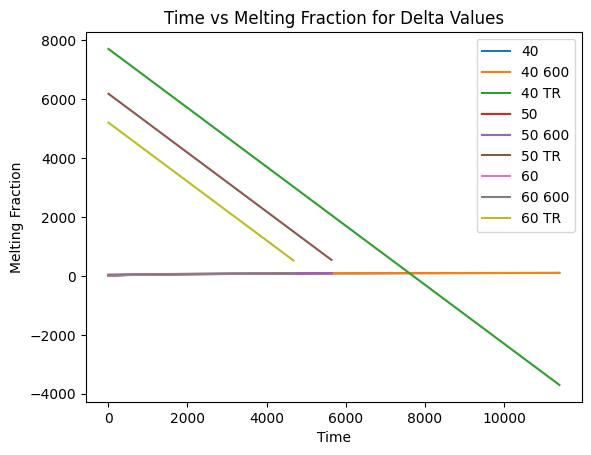

In [ ]:
columns = ['Delta', 'Time', 'MF', 'MF+300', 'MF+600']

import matplotlib.pyplot as plt

groups = df1.groupby('Delta')

# plot time vs fraction for each delta value separately
for name, group in groups:
  plt.plot(group['Time'], group['MF'], label=name)
  plt.plot(group['Time'], group['MF_600'], label=str(name) + " 600")
  plt.plot(group['Time'], group['TR'], label=str(name) + " TR")
  # plt.plot(group['Time'], group['MF+3600'], label=str(name) + " 3600")
  # break

# set plot title and axis labels
plt.title('Time vs Melting Fraction for Delta Values')
plt.xlabel('Time')
plt.ylabel('Melting Fraction')

# add legend to the plot
plt.legend()

# display the plot
plt.show()

##ANN

In [42]:
df1 = pd.read_csv('sample_data_v2.csv')
# df1 = df1.drop('MF_4', axis=1)
df1['TR'] = df1['TR']/100
print(df1)
df1 = df1.groupby(['Delta', 'MF']).mean().reset_index()
print(df1)

      Delta    Time      MF  MF_600     TR
0        40     4.0   0.231    31.0  76.96
1        40     8.0   0.462    31.1  76.92
2        40    12.0   0.693    31.1  76.88
3        40    16.0   0.924    31.1  76.84
4        40    20.0   1.150    31.1  76.80
...     ...     ...     ...     ...    ...
5436     60  4680.0  86.700    90.4   5.20
5437     60  4680.0  86.700    90.4   5.20
5438     60  4680.0  86.700    90.4   5.20
5439     60  4680.0  86.800    90.4   5.20
5440     60  4680.0  86.800    90.4   5.20

[5441 rows x 5 columns]
      Delta      MF    Time  MF_600     TR
0        40   0.231     4.0  31.000  76.96
1        40   0.462     8.0  31.100  76.92
2        40   0.693    12.0  31.100  76.88
3        40   0.924    16.0  31.100  76.84
4        40   1.150    20.0  31.100  76.80
...     ...     ...     ...     ...    ...
2160     60  86.400  4625.0  90.025   5.75
2161     60  86.500  4640.0  90.100   5.60
2162     60  86.600  4660.0  90.300   5.40
2163     60  86.700  4675.0  

In [43]:
# split the data into train and test set

# df1.columns = ['Delta', 'Time', 'MF', 'MF_60', 'MF_600']
df1 = df1[df1['MF'] != df1['MF_600']]
trainval, test = train_test_split(df1, test_size=0.10, random_state=42, shuffle=True)
train, val = train_test_split(trainval, test_size=0.11111, random_state=42, shuffle=True)

In [44]:
test = test.reset_index(drop=True)
test = test.sort_values(['Delta', 'MF'], ascending=[True, True])

In [45]:
x = train.iloc[:,:3]
x = x.drop('Time', axis=1)
y = train.iloc[:, 3:]
x_val = val.iloc[:,:3]
x_val = x_val.drop('Time', axis=1)
y_val = val.iloc[:, 3:]
print(x)
print(y)

      Delta    MF
1613     60  31.7
1631     60  33.5
1780     60  48.4
2026     60  73.0
489      40  65.0
...     ...   ...
1919     60  62.3
1612     60  31.6
215      40  37.6
1099     50  46.6
2161     60  86.5

[1731 rows x 2 columns]
      MF_600     TR
1613   45.30  47.24
1631   47.60  46.28
1780   59.00  39.90
2026   79.50  21.80
489    69.70  43.40
...      ...    ...
1919   69.50  30.80
1612   45.25  47.30
215    46.90  66.20
1099   57.10  48.40
2161   90.10   5.60

[1731 rows x 2 columns]


In [48]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Define the model architecture
'''
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,), kernel_initializer='he_normal', bias_initializer="zeros"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal', bias_initializer="zeros"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal', bias_initializer="zeros"),
    tf.keras.layers.Dense(1)
])
'''

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu', input_shape=(2,), kernel_initializer='he_normal'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer='he_normal'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='relu', kernel_initializer='he_normal'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer='he_normal', bias_initializer="zeros"),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

##################################################
model.load_weights('final_weights_v2_final.h5')
##################################################

# early_stop = EarlyStopping(monitor='val_loss', patience=25)
# M = model.fit(x, y, epochs=1200, validation_data=(x_val, y_val), callbacks=[early_stop])

In [11]:
# Plot the loss curve
plt.plot(M.history['loss'], label = 'loss')
plt.plot(M.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend()
plt.show()

# loss_history = np.array(M.history['loss'])
# file_path = "loss_history_v2_temp.csv"
# np.savetxt(file_path, loss_history)


# val_loss_history = np.array(M.history['val_loss'])
# file_path = "val_loss_history_v2_temp.csv"
# np.savetxt(file_path, val_loss_history)

NameError: ignored

In [49]:
# x_test = test.Time.values
x_test = test.iloc[:,:3]
x_test = x_test.drop('Time', axis=1)
y_test = test.iloc[:, 3:]

# Evaluate the model on the test data
val_loss = model.evaluate(x_val, y_val)
loss = model.evaluate(x_test, y_test)
train_loss = model.evaluate(x, y)

# Print the test loss and accuracy
print('Train loss:', train_loss)
print('Val loss:', val_loss)
print('Test loss:', loss)

55/55 [==============================] - 0s 1ms/step - loss: 1.5937
Train loss: 1.593672513961792
Val loss: 1.7060139179229736
Test loss: 1.5957962274551392


1/1 [==============================] - 0s 31ms/step


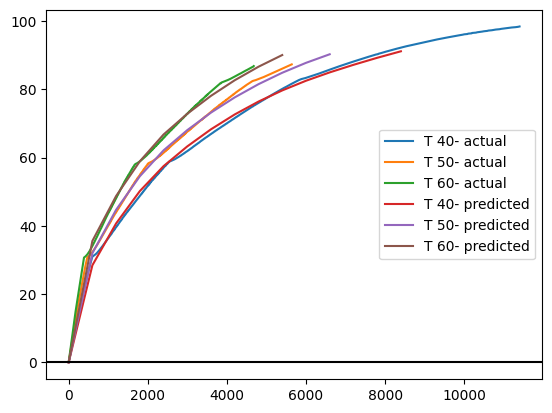

In [83]:
groups = df1.groupby('Delta')
for name, group in groups:
  plt.plot(group['Time'], group['MF'], label="T " + str(name)+"- actual")

for i in [40,50,60]:
  t = 0
  mf = 0
  y_pred = np.zeros((1, 2))
  t = t + 600
  y_step = model.predict(np.array([[[i],[mf]]]))
  mf = y_step[0,0]
  y_pred = np.vstack((y_pred,  np.array([[t, mf]])))
  # print(mf)
  # print(y_pred)

  while mf <= 90:
    t = t + 600
    y_step = model.predict(np.array([[[i],[mf]]]), verbose = 0)
    mf = y_step[0,0]
    y_pred = np.vstack((y_pred,  np.array([[t, mf]])))
  

  plt.plot(y_pred[:,0], y_pred[:,1], label="T " + str(i)+"- predicted")
  # print(y_pred)
  # y_pred = np.array(y_pred)
  # print(y_pred)
  # file_path = "Predicted_MF_V2" + str(i) + ".csv"
  # np.savetxt(file_path, y_pred)

plt.axhline(y=0, color='black')


plt.legend()
plt.show()


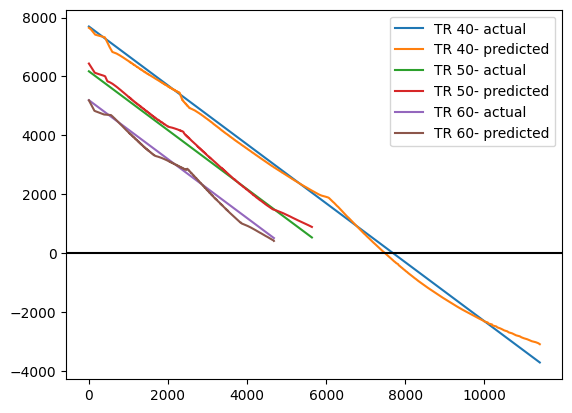

In [84]:
groups = df1.groupby('Delta')
for name, group in groups:
  plt.plot(group['Time'], group['TR']*100, label="TR " + str(name)+"- actual")
  
  a = np.array([[group['Delta'],group['MF']]])
  b = np.transpose(a)
  y_pred = model.predict(b, verbose = 0)
  plt.plot(group['Time'], y_pred[:,1]*100, label="TR " + str(name)+"- predicted")
  # y_pred = np.array([group['Time'], group['TR']*100, y_pred[:,1]*100])
  # print(y_pred)
  # file_path = "Predicted_TR_V2" + str(name) + ".csv"
  # np.savetxt(file_path, np.transpose(y_pred), delimiter=',')
  # break
plt.axhline(y=0, color='black')


plt.legend()
plt.show()


In [36]:
# model.save_weights('final_weights_v2_final.h5')

In [ ]:
def construct_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu', input_shape=(2,), kernel_initializer='he_normal'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer='he_normal'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8, activation='relu', kernel_initializer='he_normal'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer='he_normal', bias_initializer="zeros"),
    tf.keras.layers.Dense(2)
  ])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

  return model



In [ ]:
!pip install visualkeras
!pip install ann_visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4167 sha256=573f8b64fc0e3a5d2c5a9055d5c7b406e741016fde72e3d95c74a87225f45b22
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer


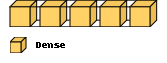

In [ ]:
from ann_visualizer.visualize import ann_viz
model = construct_model()
ann_viz(model, view=True, filename="sample_model", title="ANN Architecture")

import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)
